<a href="https://colab.research.google.com/github/pranathadoddy/gender-prediction/blob/main/resnet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [141]:
import os
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image

In [142]:
BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [144]:
dfGender = pd.read_csv('/content/drive/MyDrive/DataCelebA/list_attribute.txt', sep="\s+", skiprows=1, usecols=['Male'])
dfGender.loc[dfGender['Male'] == -1, 'Male'] = 0
dfGender.head()

Male
000001.jpg     0
000002.jpg     0
000003.jpg     1
000004.jpg     0
000005.jpg     0

In [145]:
filenames = os.listdir("/content/drive/MyDrive/Images/")
dfGender = dfGender[dfGender.index.isin(filenames)]


dfGender.head()

Male
000051.jpg     1
000052.jpg     1
000065.jpg     1
000166.jpg     1
000198.jpg     0

(218, 178, 3)
(218, 178, 3)
(218, 178, 3)


Text(0.5, 1.0, '(218, 178, 3)')

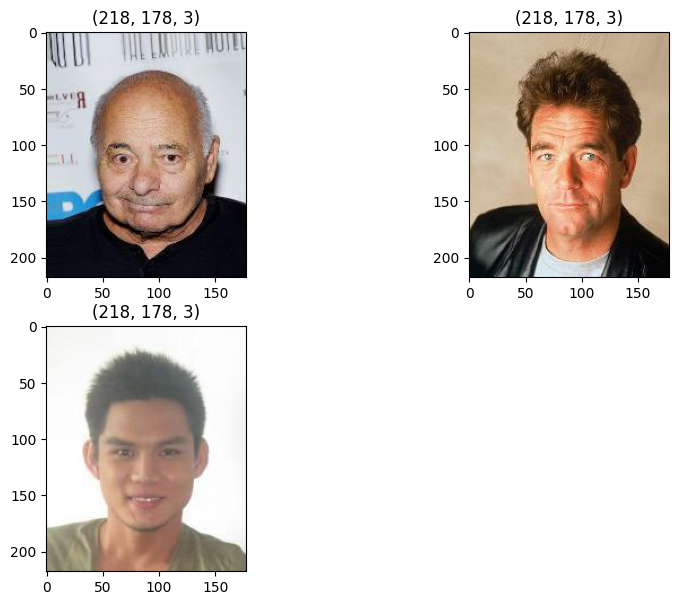

In [146]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(2, 2, 1)

img1 = Image.open('/content/drive/MyDrive/Images/000051.jpg')
print(np.asarray(img1, dtype=np.uint8).shape)
plt.imshow(img1);
plt.title(np.asarray(img1, dtype=np.uint8).shape)

fig.add_subplot(2, 2, 2)

img2 = Image.open('/content/drive/MyDrive/Images/000052.jpg')
print(np.asarray(img2, dtype=np.uint8).shape)
plt.imshow(img2);
plt.title(np.asarray(img2, dtype=np.uint8).shape)

fig.add_subplot(2, 2, 3)

img3 = Image.open('/content/drive/MyDrive/Images/000065.jpg')
print(np.asarray(img3, dtype=np.uint8).shape)
plt.imshow(img3);
plt.title(np.asarray(img3, dtype=np.uint8).shape)

In [147]:
dfPartition = pd.read_csv('/content/drive/MyDrive/DataCelebA/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
dfPartition.columns = ['Filename', 'Partition']
dfPartition = dfPartition.set_index('Filename')

dfPartition = dfPartition[dfPartition.index.isin(filenames)]
dfPartition.head()

Partition
Filename             
000051.jpg          0
000052.jpg          0
000065.jpg          0
000166.jpg          0
000198.jpg          0

In [148]:
dfGenderPartition = dfGender.merge(dfPartition, left_index=True, right_index=True)
dfGenderPartition.head()

Male  Partition
000051.jpg     1          0
000052.jpg     1          0
000065.jpg     1          0
000166.jpg     1          0
000198.jpg     0          0

In [149]:
dfGenderPartition.loc[dfGenderPartition['Partition'] == 0].to_csv('gender_train.csv')
dfGenderPartition.loc[dfGenderPartition['Partition'] == 1].to_csv('gender_valid.csv')
dfGenderPartition.loc[dfGenderPartition['Partition'] == 2].to_csv('gender_test.csv')



# Data Loader

In [150]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets

from torchvision import datasets
from torchvision import transforms

from torchvision import models

In [151]:
class ImageGenderDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [152]:


custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       transforms.ToTensor()])


train_dataset = ImageGenderDataset(csv_path='gender_train.csv',
                              img_dir='/content/drive/MyDrive/Images/',
                              transform=custom_transform)

valid_dataset = ImageGenderDataset(csv_path='gender_valid.csv',
                              img_dir='/content/drive/MyDrive/Images/',
                              transform=custom_transform)

test_dataset = ImageGenderDataset(csv_path='gender_test.csv',
                             img_dir='/content/drive/MyDrive/Images/',
                              transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

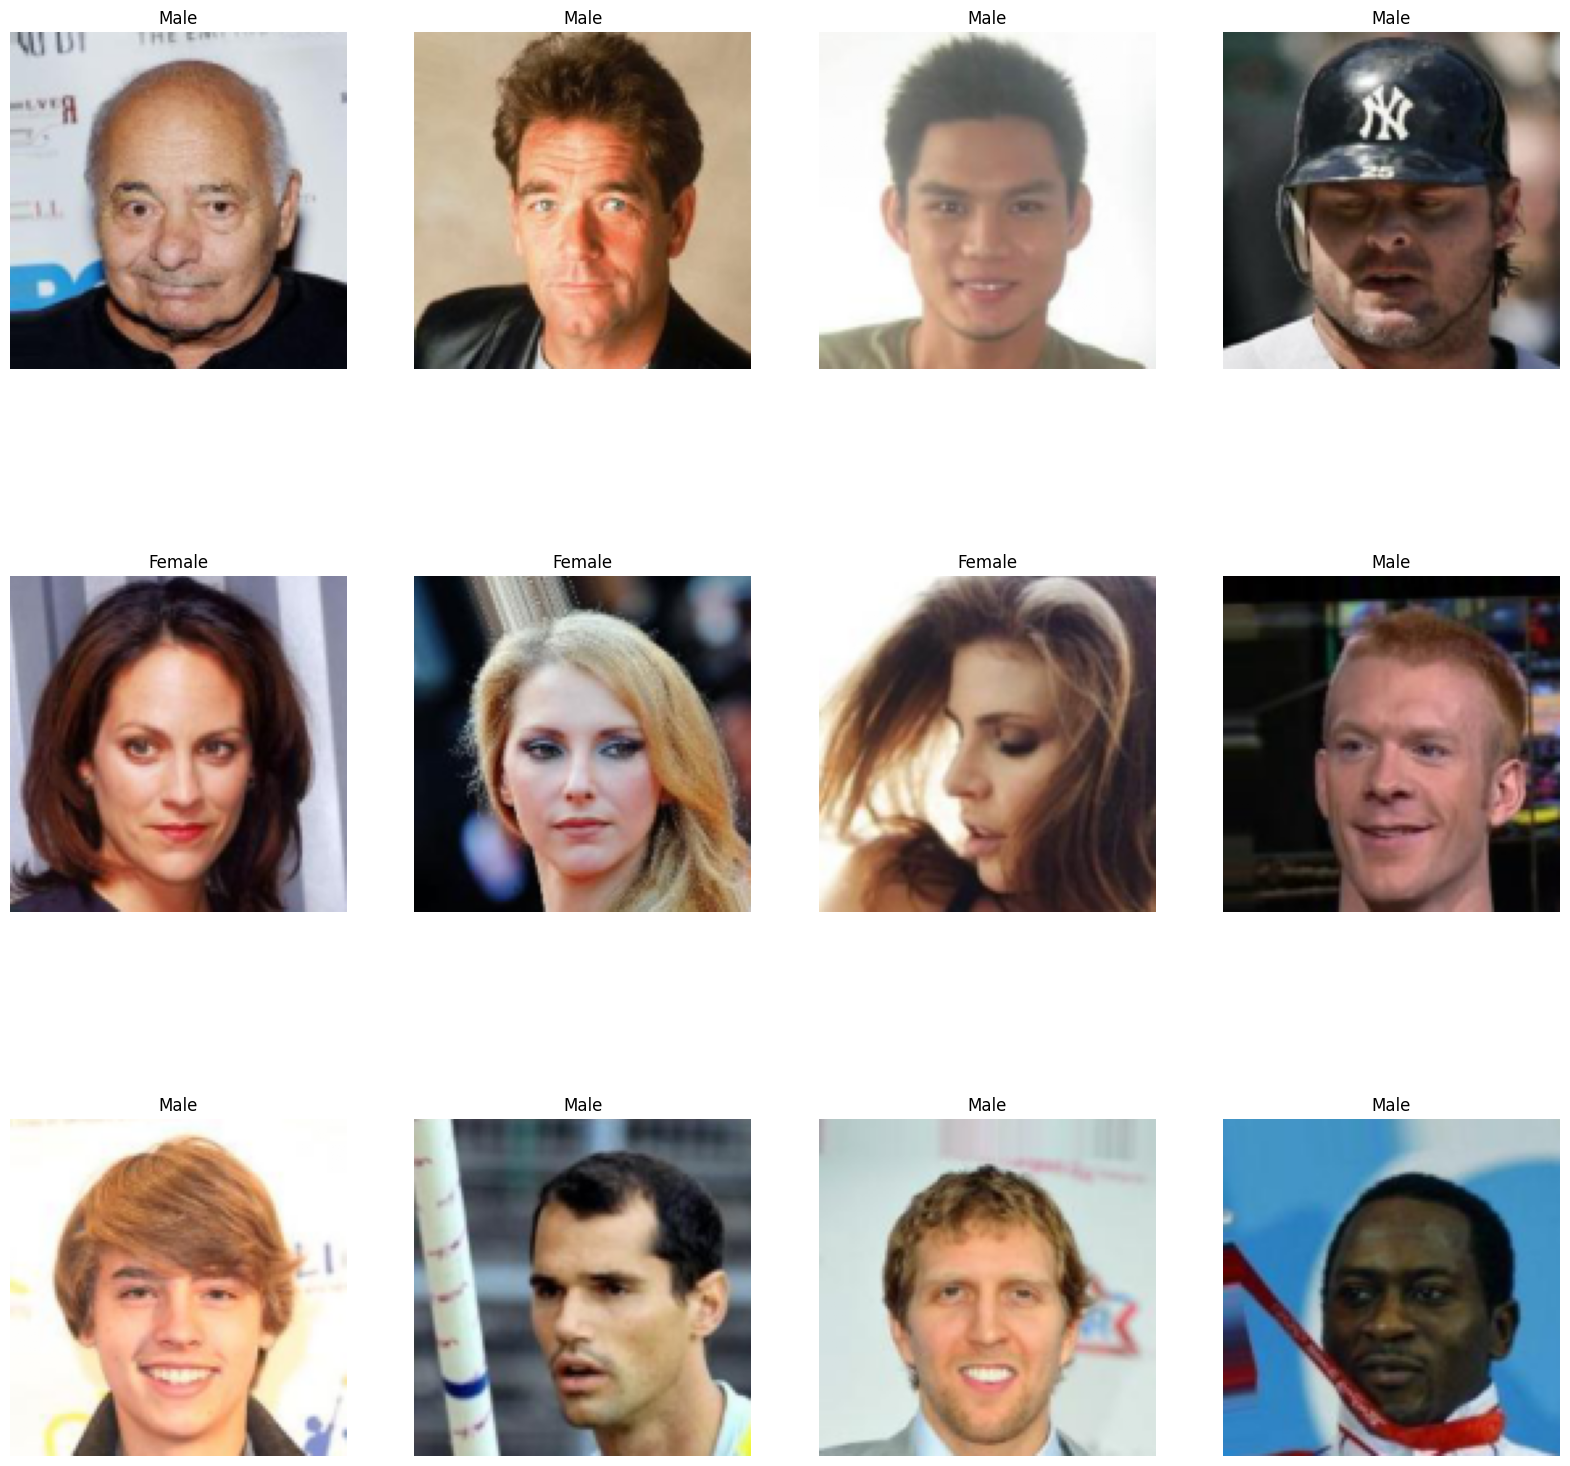

In [187]:
fig = plt.figure(figsize=(20,20))

for i, train in enumerate(train_dataset):

    fig.add_subplot(3, 4, i + 1)

    gender =  "Male" if train[1] == 1 else "Female"
    plt.title(gender)
    plt.axis('off')

    plt.imshow(np.transpose(train[0], (1, 2, 0)))

    if i == 11:
        plt.show()
        break

In [154]:
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):

        x = x.to(DEVICE)
        y = y.to(DEVICE)
        time.sleep(1)
        break

# Training

In [155]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

https://pytorch.org/docs/0.4.0/_modules/torchvision/models/resnet.html

In [156]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=2,
                   grayscale=grayscale)
    return model


In [157]:
torch.manual_seed(1)

model = resnet34(num_classes=2, grayscale=False)

model.to(DEVICE)

cost_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [158]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100



trainingEpoch_loss = []
validationEpoch_loss = []

trainingEpoch_accuracy = []
validationEpoch_accuracy = []

for epoch in range(NUM_EPOCHS):
    step_loss = []
    model.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        optimizer.step()
        step_loss.append(cost.item())

        if not batch_idx % 5:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))
    trainingEpoch_loss.append(np.array(step_loss).mean())

    model.eval()
    validationStep_loss = []
    for batch_idx, (features, targets) in enumerate(valid_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        optimizer.step()
        validationStep_loss.append(cost.item())

    validationEpoch_loss.append(np.array(validationStep_loss).mean())

    with torch.set_grad_enabled(False): # save memory during inference
        train_accuracy = compute_accuracy(model, train_loader, device=DEVICE)
        valid_accuracy = compute_accuracy(model, valid_loader, device=DEVICE)
        print('Epoch: {} | Train: {} | Valid: {}'.format(
              epoch+1, NUM_EPOCHS,
              train_accuracy,
              valid_accuracy))
        trainingEpoch_accuracy.append(train_accuracy)
        validationEpoch_accuracy.append(valid_accuracy)

Epoch: 001/010 | Batch 0000/0041 | Cost: 0.6834
Epoch: 001/010 | Batch 0005/0041 | Cost: 0.7162
Epoch: 001/010 | Batch 0010/0041 | Cost: 0.6845
Epoch: 001/010 | Batch 0015/0041 | Cost: 0.6616
Epoch: 001/010 | Batch 0020/0041 | Cost: 0.5486
Epoch: 001/010 | Batch 0025/0041 | Cost: 0.4854
Epoch: 001/010 | Batch 0030/0041 | Cost: 0.4954
Epoch: 001/010 | Batch 0035/0041 | Cost: 0.3164
Epoch: 001/010 | Batch 0040/0041 | Cost: 0.2223
Epoch: 1 | Train: 10 | Valid: 58.4244499206543
Epoch: 002/010 | Batch 0000/0041 | Cost: 0.4556
Epoch: 002/010 | Batch 0005/0041 | Cost: 0.4223
Epoch: 002/010 | Batch 0010/0041 | Cost: 0.4332
Epoch: 002/010 | Batch 0015/0041 | Cost: 0.3986
Epoch: 002/010 | Batch 0020/0041 | Cost: 0.2888
Epoch: 002/010 | Batch 0025/0041 | Cost: 0.2586
Epoch: 002/010 | Batch 0030/0041 | Cost: 0.2563
Epoch: 002/010 | Batch 0035/0041 | Cost: 0.3979
Epoch: 002/010 | Batch 0040/0041 | Cost: 0.3340
Epoch: 2 | Train: 10 | Valid: 41.57554626464844
Epoch: 003/010 | Batch 0000/0041 | Cost: 

<function matplotlib.pyplot.show(close=None, block=None)>

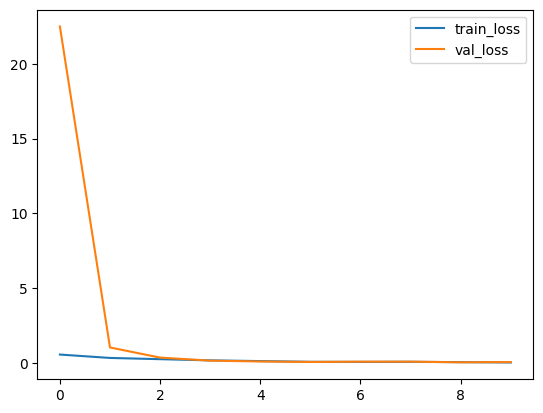

In [159]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

In [160]:
train_accuracy.shape

torch.Size([])

# Evaluation

In [165]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Accuracy: {}'.format(compute_accuracy(model, test_loader, device=DEVICE)))

Accuracy: 88.30644989013672


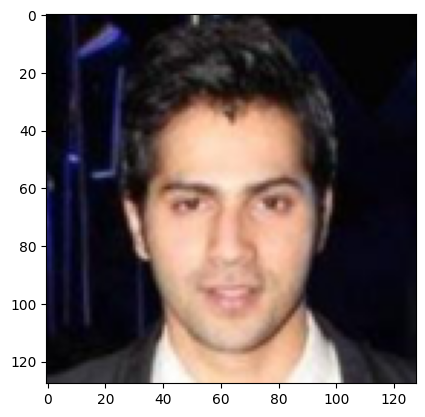

In [166]:
for index, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [174]:
features.to(DEVICE)[0, None].shape

torch.Size([1, 3, 128, 128])

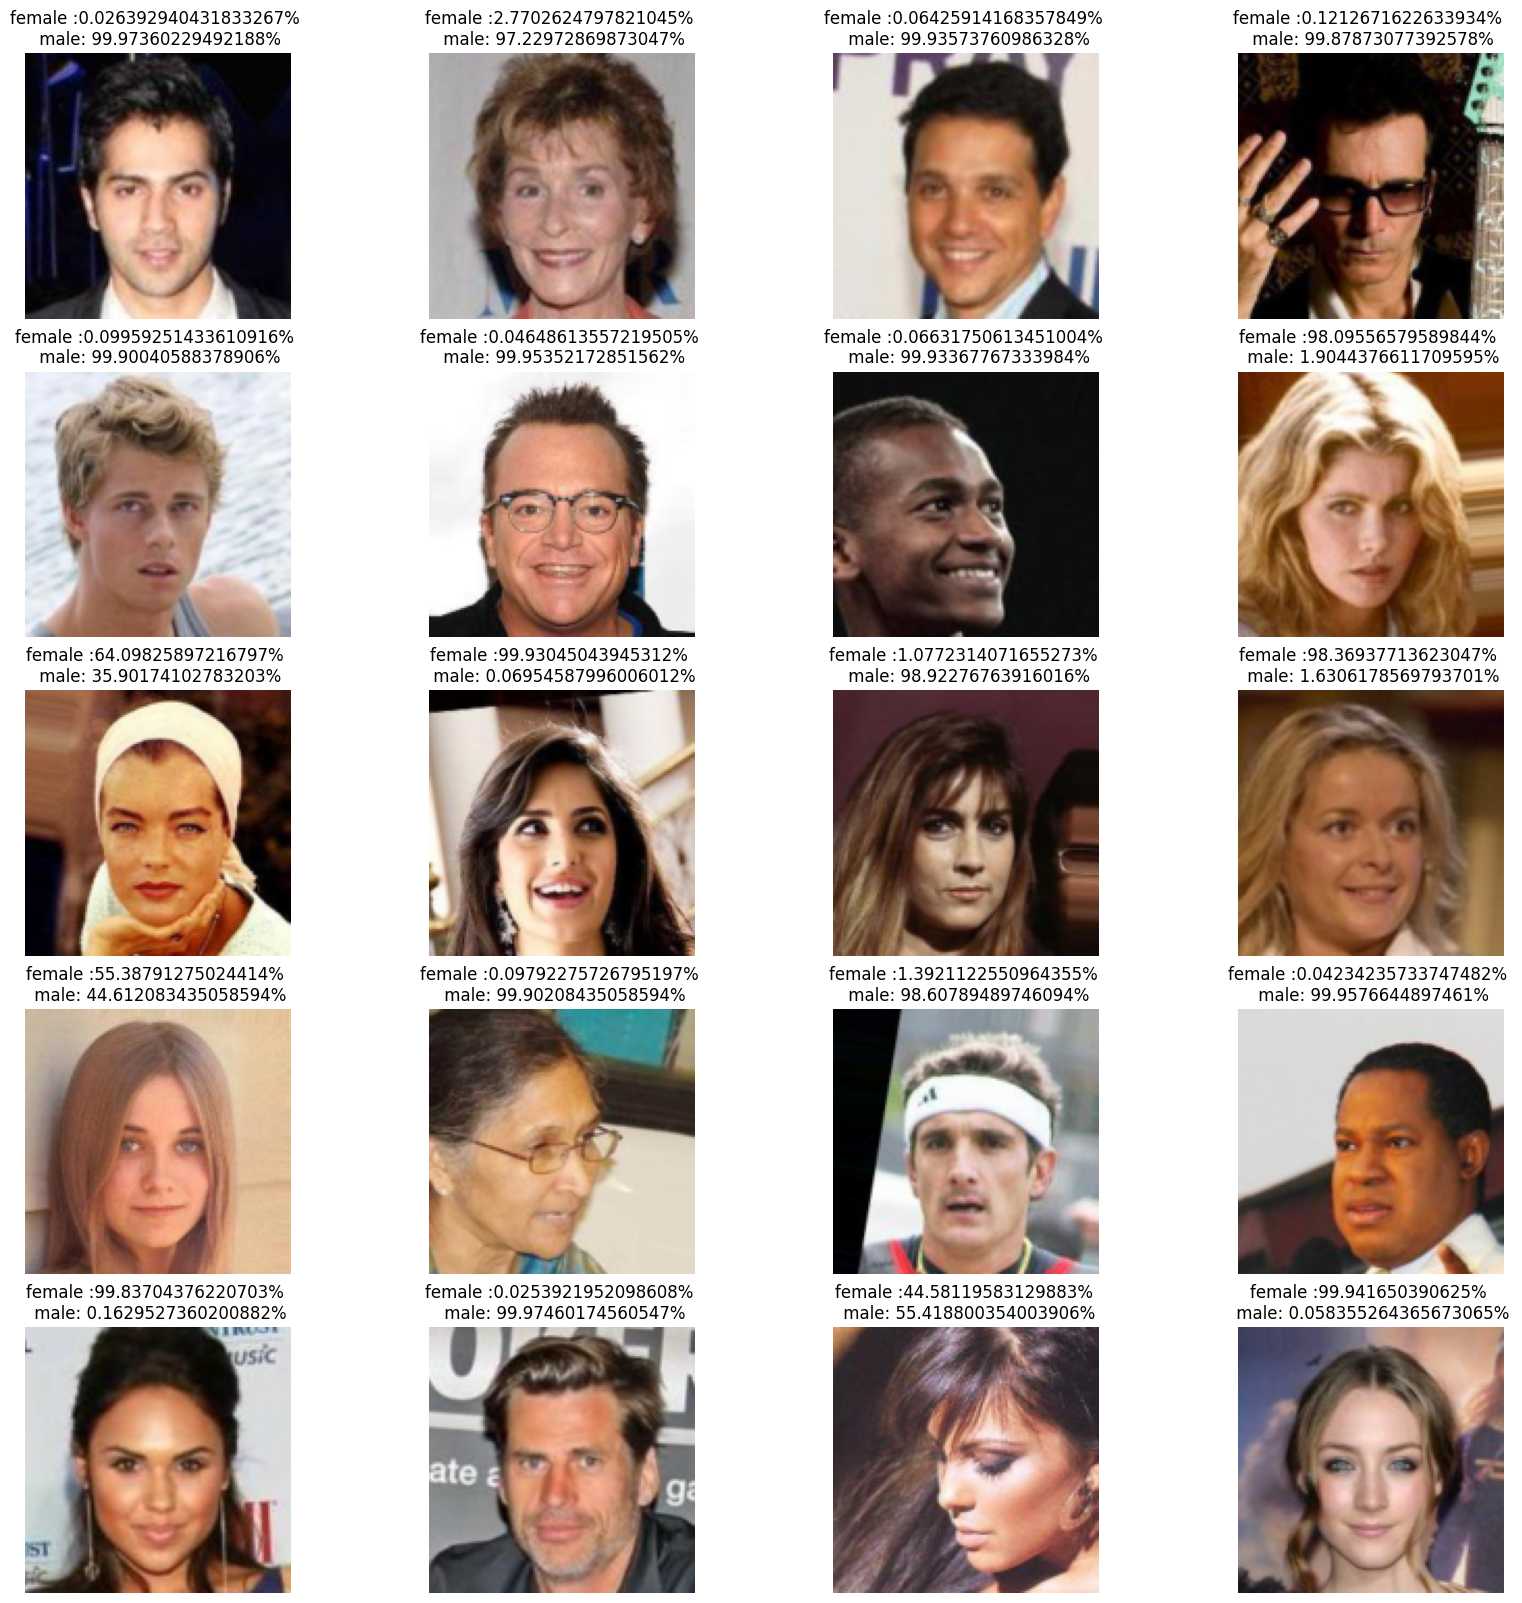

In [186]:
model.eval()

fig = plt.figure(figsize=(20,20))
for index, feature in enumerate(features):
  logits, probas = model(features[index, None].to(DEVICE))

  fig.add_subplot(5, 4, index + 1)
  plt.title('female :{}% \n male: {}%'.format(probas[0][0]*100, probas[0][1]*100))
  plt.axis('off')
  plt.imshow(np.transpose(feature, (1, 2, 0)))
  if index == 19:
    plt.show()
    break
